In [2]:
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage import data, color, feature
import matplotlib
import matplotlib.pyplot as plt
import skimage.data
%matplotlib inline
from keras.preprocessing import image
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

### Histogram of Oriented Gradients(HOG)

#### Features to be extracted

- HOG convolves the images with two filters that are sensitive to horizontal and vertical brightness gradients--allowing us to capture edge, contour, and texture information

- HOG also subdivides the images into cells of a predetermined size, and computes histograms of the gradient orientations within each cell.

- Data is normalized in each cell and the result is a one dimensional feature vector made from the information in each cell of an image. 

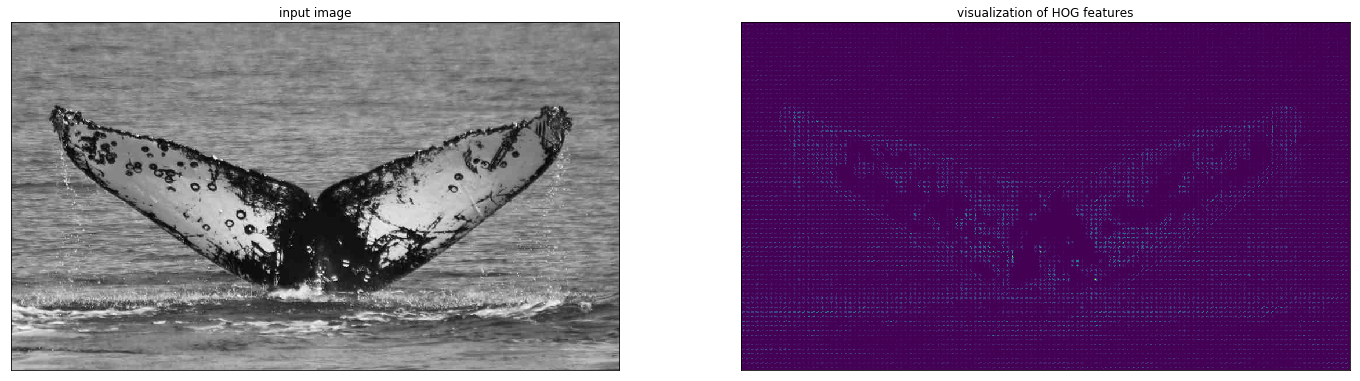

In [4]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage import data, color, feature
import skimage.data

image = load_img('D:/Whales!!/NEW/data/train/5/1fb990d1.jpg', grayscale=True)
im = img_to_array(image)
im2 = im[:, :,0]

hog_vec, hog_vis = feature.hog(im2, block_norm = str('L2-Hys'), visualise=True) #feature_vector = true for 1D output
fig, ax = plt.subplots(1, 2, figsize=(24, 12), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(im2, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

Function to extract hot feature vector
hog vec is 1d array

In [3]:
def customizedDataAugmentation(x):
    #image = load_img(x)
    im = img_to_array(x)
    im2 = im[:, :,0]
    #we can save 1D somewhere or just use flatten after import
    hog_vec, hog_vis = feature.hog(im2, block_norm = str('L2-Hys'), visualise=True) 
    #convert back to 3D image type
    #aal = np.asarray(hog_vis)
    #xxy = aal[:,:,np.newaxis]
    #zzy = array_to_img(xxy)
    #xxy = xxy.reshape(-1,)
    return hog_vec#, zzy

Load the dataset

In [6]:
Data = pd.read_csv('new_train_whole.csv', sep = '\t')
X_list = Data.Image.tolist()
y = Data.newID.tolist()

Create hog vector matrix

In [5]:
X = np.zeros((len(X_list),8100))
path = 'C:\\Users\\charlie\\Desktop\\177\\whale\\augmentation\\'
i=0
for x in X_list:
    img = image.load_img(path+x, target_size=(100, 100))
    s= customizedDataAugmentation(img)
    X[i,:] = s
    i+=1
print(X.shape)

(2256, 8100)


### Naive Test of Various Classifiers

- We select the best two classifiers to perform gridsearch on
- In this case, the best two were SVM (SVC) and K-NN

In [27]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=100, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 19.9409%
Log Loss: 17.849415387393172
SVC
****Results****
Accuracy: 41.8021%
Log Loss: 3.1330715145841355
NuSVC
****Results****
Accuracy: 6.6470%
Log Loss: 3.7058826960689952
DecisionTreeClassifier
****Results****
Accuracy: 10.6352%
Log Loss: 30.865523957047262
RandomForestClassifier
****Results****
Accuracy: 14.3279%
Log Loss: 19.576194929467743


### SVM gridsearch

In [63]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

Gridsearch for the linear kernal

In [64]:
from sklearn.model_selection import StratifiedKFold
scores = []
i = 0
for c in tuned_parameters[1]['C']:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, stratify = y, random_state  = i)
    i+=1
    clf = svm.SVC(C = c, kernel='linear')
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    scores.append(metrics.f1_score(y_test,y_pred, average='weighted'))
    print('C:{}'.format(c))
    print(metrics.f1_score(y_test,y_pred, average='weighted'))

C:\Users\charlie\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C:1
0.06401869235895256
C:10
0.28384325142008826
C:100
0.40259227145602594
C:1000
0.3864642851521056


Gridsearch for the rbf kernal

In [65]:
from sklearn.model_selection import StratifiedKFold
scores = []
i = 0
for c in tuned_parameters[0]['C']:
    for g in tuned_parameters[0]['gamma']:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, stratify = y, random_state  = i)
        i+=1
        clf = svm.SVC(C = c, gamma = g, kernel='rbf')
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        scores.append(metrics.f1_score(y_test,y_pred, average='weighted'))
        print('C:{} gamma:{}'.format(c, g))
        print(metrics.f1_score(y_test,y_pred, average='weighted'))

C:\Users\charlie\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C:1 gamma:0.001
0.0028407479235435388
C:1 gamma:0.0001
0.0028407479235435388
C:10 gamma:0.001
0.0056061152001326085
C:10 gamma:0.0001
0.0028407479235435388
C:100 gamma:0.001
0.01284409885664545
C:100 gamma:0.0001
0.0028610971207035925
C:1000 gamma:0.001
0.11228289619226879
C:1000 gamma:0.0001
0.021349009965633287


Linear had the best results

Split the data and fit

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, stratify = y, random_state  = 0)
clf = svm.SVC(C= 100, kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [67]:
y_pred = clf.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.40620384047267355


             precision    recall  f1-score   support

          0       0.44      0.69      0.54        26
          1       0.33      0.39      0.36        18
          2       0.22      0.20      0.21        10
          3       0.40      0.33      0.36        12
          4       0.46      0.69      0.55        16
          5       0.25      0.08      0.12        12
          6       0.29      0.38      0.33        13
          7       0.39      0.54      0.45        13
          8       0.50      0.39      0.44        18
          9       0.20      0.08      0.12        12
         10       0.45      0.71      0.56        14
         11       0.80      0.80      0.80        10
         12       0.63      0.80      0.71        15
         13       0.27      0.31      0.29        13
         14       0.33      0.30      0.32        10
         15       0.30      0.73      0.42        22
         16       0.28      0.24      0.26        21
         17  

### K-NN
Girdsearch for parameter k in K-nn

In [28]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
k_range = list(range(1, 31))
k_scores = []
i=0
for k in k_range:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, stratify = y, random_state  = i)
    i+=1
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    score = (metrics.f1_score(y_test,y_pred, average='weighted'))
    print(k)
    k_scores.append(score)
    print(metrics.f1_score(y_test,y_pred, average='weighted'))

1
0.4106877343679521


C:\Users\charlie\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2
0.2552894716521166
3
0.19832728419760676
4
0.16732524765830292
5
0.16738647871961781
6
0.14029391531478064
7
0.13949891246397894
8
0.12444647306181308
9
0.1228951111517077
10
0.10584828493905997
11
0.11025770932298239
12
0.12107788461375907
13
0.10064620764179115
14
0.09260694656853424
15
0.10997661904846034
16
0.08681055681032679
17
0.0929830385190175
18
0.08228228802776127
19
0.08580774910972196
20
0.09180822900142332
21
0.07866429856547515
22
0.07263863693195766
23
0.10048269549588881
24
0.08538660563819185
25
0.09823148416634428
26
0.0913874684302701
27
0.07370993971269414
28
0.07865128401262612
29
0.06851118824006885
30
0.06492216554400844


K = 1 gave the highest accuracy, so we go with that value. 

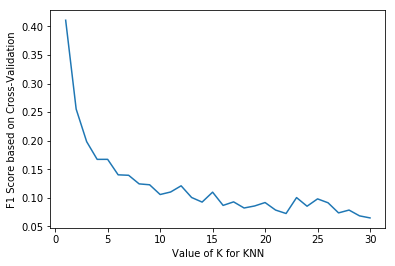

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 Score based on Cross-Validation')
plt.show()

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.4254062038404727


             precision    recall  f1-score   support

          0       0.67      0.54      0.60        26
          1       0.71      0.28      0.40        18
          2       0.57      0.40      0.47        10
          3       0.70      0.58      0.64        12
          4       0.23      0.50      0.31        16
          5       0.47      0.58      0.52        12
          6       0.62      0.38      0.48        13
          7       0.18      0.54      0.27        13
          8       0.46      0.33      0.39        18
          9       0.31      0.33      0.32        12
         10       0.53      0.57      0.55        14
         11       0.67      0.40      0.50        10
         12       0.40      0.40      0.40        15
         13       0.22      0.31      0.26        13
         14       0.56      0.50      0.53        10
         15       0.22      0.45      0.29        22
         16       0.32      0.29      0.30        21
         17   